# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np

In [2]:
from keras.datasets import mnist
from keras.layers import Input,Dense,Reshape,Flatten,BatchNormalization,LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Define Image Dimensions

In [3]:
img_rows=28
img_cols=28
channels=1
img_shape=(img_rows,img_cols,channels)

# Build the Generator

In [4]:
def build_generator():
    noise_shape=(100,)

    model=Sequential()
    model.add(Dense(256,input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise=Input(shape=noise_shape)
    img=model(noise)

    return Model(noise,img)



## Build the Discriminator

In [5]:
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)


# Compile the Models

In [6]:
optimizer=Adam(0.0002,0.5)
# Build the optimizer with the full list of trainable variables


discriminator=build_discriminator()
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 533505 

In [7]:
z = Input(shape=(100,))
img=generator(z)
discriminator.trainable=False
valid=discriminator(img)
combined=Model(z,valid)
optimizer = Adam()
optimizer.build(generator.trainable_variables + discriminator.trainable_variables)

combined.compile(loss='binary_crossentropy',optimizer=optimizer)

# Save Generated Images

In [8]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(r"C:\Users\suraj\OneDrive\DeepLearning\GAN\images\mnist_%d.png" % epoch)
    plt.close()


# Train the GAN


In [9]:
def train(epochs,batch_size=128,save_interval=50):

    (X_train,_),(_,_)=mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    half_batch = int(batch_size / 2)

    d_losses = []
    g_losses = []


    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_losses.append(d_loss)

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)

        g_loss = combined.train_on_batch(noise, valid_y)
        g_losses.append(g_loss)

        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))


        if epoch % save_interval == 0:
            save_imgs(epoch)
    
        # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label="Discriminator Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


## Train the GAN

1/1 [==============================] - 0s 195ms/step
0 [D loss: 0.805397, acc.: 9.38%] [G loss: 0.606001]
1/1 [==============================] - 0s 7ms/step
1 [D loss: 0.382109, acc.: 78.12%] [G loss: 0.512631]
1/1 [==============================] - 0s 16ms/step
2 [D loss: 0.404403, acc.: 59.38%] [G loss: 0.516757]
1/1 [==============================] - 0s 14ms/step
3 [D loss: 0.455522, acc.: 50.00%] [G loss: 0.442414]
1/1 [==============================] - 0s 12ms/step
4 [D loss: 0.507428, acc.: 50.00%] [G loss: 0.446138]
1/1 [==============================] - 0s 20ms/step
5 [D loss: 0.514982, acc.: 53.12%] [G loss: 0.507494]
1/1 [==============================] - 0s 12ms/step
6 [D loss: 0.522730, acc.: 53.12%] [G loss: 0.590866]
1/1 [==============================] - 0s 14ms/step
7 [D loss: 0.522607, acc.: 59.38%] [G loss: 0.630506]
1/1 [==============================] - 0s 14ms/step
8 [D loss: 0.475252, acc.: 65.62%] [G loss: 0.790557]
1/1 [==============================] - 0s 14ms/

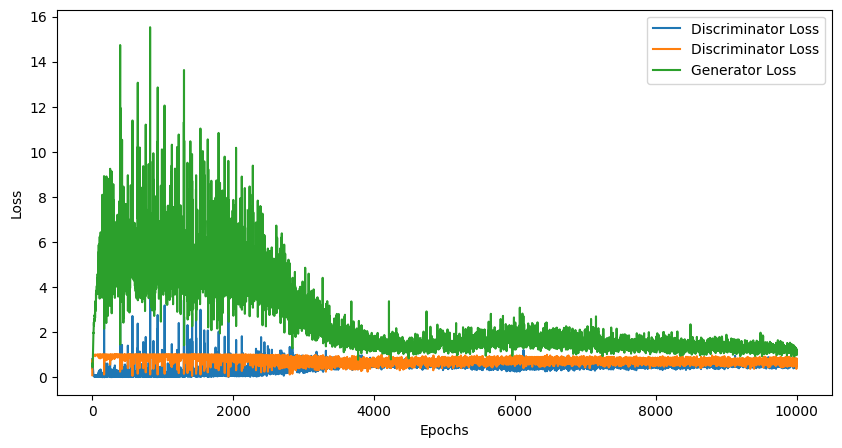

In [10]:
train(epochs=10000, batch_size=32, save_interval=10)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Save the Generator Model

In [ ]:
generator.save('generator_model.h5')


# Generate Images with the Saved Model

In [ ]:
from keras.models import load_model
from numpy import asarray
from numpy.random import randn
from matplotlib import pyplot

model = load_model('generator_model.h5')
vector = randn(100)
vector = vector.reshape(1, 100)
X = model.predict(vector)
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()


# Generate and Save Multiple Images

In [35]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def save_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

latent_points = generate_latent_points(100, 16)
X = model.predict(latent_points)
save_plot(X, 4)


NameError: name 'randn' is not defined